In [1]:
from comet_ml import Experiment

# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="tHjqql9D24vs3nj7QGbE2kxKV",
                        project_name="general", workspace="sljack")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sljack/general/3f8cd799305b4f88835cdc6a20797bf0



In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import os
import numpy as np
from pathlib import Path
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Denoising Autoencoders for Graphene EM Images

Electron microscopy (EM) images of graphene can be used to calculate the
lifetime of the structural defects and how they evolve. However, exposing them
to the EM beam will induce their decay and thus interfere with any conclusions
made. To prevent this samples can be imaged at lower doses, but as the image is
dominated by shot/Poisson noise, making the signal to noise ratio (SNR) lower to
the point where it becomes prohibitive to get any information out of the image.
We wish to reduce the noise present whilst preserving the underlying atomic
structure in the image.

In this tutorial we will create an autoencoder network that transforms a noisy input image of graphene to a clean image of graphene.

First we need to write some code to load the images from disk. Here' some boilerplate code to get you started with loading the files:

In [3]:
N_CHANNELS = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
BATCH_SIZE = 32

def hdf_generator(path, buffer_size=100):
    """ Load data DMS data from disk
    
    Args:
        path: path of the HDF file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['noise'].shape
        for i in range(0, n_samples, buffer_size):
            noise = handle['noise'][i:i+buffer_size]
            clean = handle['clean'][i:i+buffer_size]
            yield noise, clean

dataset = tf.data.Dataset.from_generator(lambda: hdf_generator(path='data/graphene/train.h5'), 
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), (None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))

**Exercise**:Use the methods of `tf.data.Dataset` to transform the input data using the following recipe:
 - Unbatch the data
 - Shuffle the data with a buffer size of 500
 - Normalise the inputs to the range -1, 1. 
     - *Hint*: use the `map` function
     - *Hint*: the formula for this is: $$2 \frac{x -  min(x)}{max(x) - min(x)} - 1$$
 - Batch the dataset to size 32

In [4]:
def normalize_inputs(X, Y):
    X = 2 * (X - tf.reduce_min(X)) / (tf.math.reduce_max(X) - tf.math.reduce_min(X)) - 1
    Y = 2 * (Y - tf.reduce_min(Y)) / (tf.math.reduce_max(Y) - tf.math.reduce_min(Y)) - 1
    return X, Y

# dataset = tf.data.Dataset.from_tensor_slices((graphene_noise, graphene_clean))
dataset = dataset.unbatch()
dataset = dataset.shuffle(500)
dataset = dataset.take(1000)
dataset = dataset.map(normalize_inputs)
dataset = dataset.batch(BATCH_SIZE)

Once you've loaded the data we can plot a could of examples. The two row should show the noisy examples and the bottom row should show the clean (denoised) examples

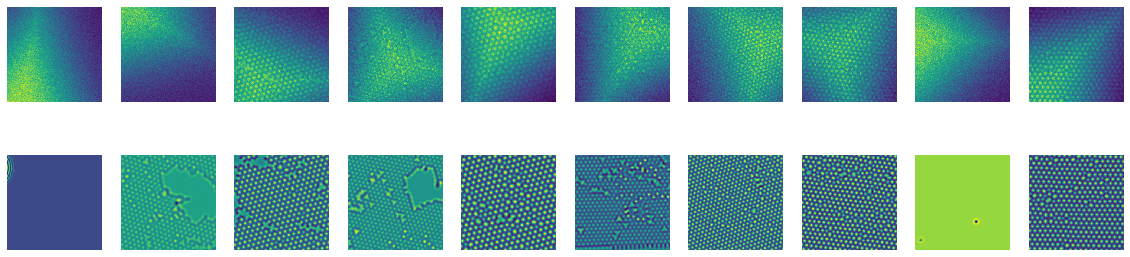

In [5]:
data = list(dataset.take(1))[0]
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for ax, img_noise, img_clean in zip(axes.T, data[0][:10], data[1][:10]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].axis('off')
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].axis('off')

**Exercise**: Write an autoencoder which takes the noisy images as input and the clean images as output. You can use any architecture you like, but it must take and produce images of size `(256, 256, 1)` as input and output.

In [6]:
def autoencoder(img_height, img_width, n_channels=1):
    skip_layers = []
    
    input_layer = tf.keras.layers.Input((img_height, img_width, n_channels))
    x = input_layer
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    skip_layers.append(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    skip_layers.append(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    skip_layers.append(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, skip_layers.pop(-1)])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, skip_layers.pop(-1)])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, skip_layers.pop(-1)])
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  
    
    x = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation='linear', padding='same')(x)
    
    model = tf.keras.models.Model(input_layer, x)
    return model

**Exercise**: Once you have a working network consider these extension exercises:
        
 - Try different types of augmentation, does this improve your predictions?
 - Write a custom loss function that uses [SSIM](https://en.wikipedia.org/wiki/Structural_similarity). *Hint:* you can use `tf.image.ssim` to help you.

In [7]:
model = autoencoder(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS)
model.summary()

def ssim_loss(y_actual, y_pred):
    ssim = tf.image.ssim(y_actual, y_pred, max_val=2.0)
    return 1 - tf.reduce_mean(ssim)

model.compile(optimizer='adam', loss=ssim_loss)
model.fit(dataset, epochs=50)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         batch_normalization[0][0]        
______________________________________________________________________________________________

COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


32/32 [==============================] - 9s 296ms/step - loss: 0.8241
Epoch 2/50
32/32 [==============================] - 5s 169ms/step - loss: 0.5914
Epoch 3/50
32/32 [==============================] - 5s 164ms/step - loss: 0.5784
Epoch 4/50
32/32 [==============================] - 5s 166ms/step - loss: 0.5378
Epoch 5/50
32/32 [==============================] - 5s 169ms/step - loss: 0.5262
Epoch 6/50
32/32 [==============================] - 5s 166ms/step - loss: 0.5156
Epoch 7/50
32/32 [==============================] - 5s 163ms/step - loss: 0.5213
Epoch 8/50
32/32 [==============================] - 5s 165ms/step - loss: 0.5050
Epoch 9/50
32/32 [==============================] - 5s 166ms/step - loss: 0.5068
Epoch 10/50
32/32 [==============================] - 5s 166ms/step - loss: 0.5047
Epoch 11/50
32/32 [==============================] - 5s 165ms/step - loss: 0.4961
Epoch 12/50
32/32 [==============================] - 5s 163ms/step - loss: 0.4895
Epoch 13/50
32/32 [=================

Text(0.5, 1.05, 'Model Output')

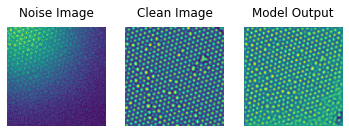

In [63]:
img_noise, img_clean = list(dataset.take(1))[0]
out = model.predict(img_noise)
out = np.squeeze(out)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.matshow(img_noise[0, ..., 0])
ax1.axis('off')
ax1.set_title('Noise Image')
ax2.matshow(img_clean[0, ..., 0])
ax2.axis('off')
ax2.set_title('Clean Image')
ax3.matshow(out[0])
ax3.axis('off')
ax3.set_title('Model Output')